# Assessing the Stiffness of a Network

Reaction networks with a wide range of rate timescales can be stiff, generally requiring implicit integrators.  Sometimes there might be only a single rate that is responsible for the stiffness, and in this case, it might be possible to do an approximation to alleviate some of the stiffness.

Here we look at how to characterize the stiffness of the rate.

For a network of the form:

$$\frac{d{\bf Y}}{dt} = {\bf f}({\bf Y})$$

We construct the Jacobian as:

$${\bf J} = \frac{\partial \dot{\bf Y}}{\partial {\bf Y}}$$

If we compute the eigenvalues $\lambda_i$, of ${\bf J}$, then a stiff reaction network is characterized by:

$$\frac{\max_i\{|\lambda_i|\}}{\min_i\{|\lambda_i|\}} \gg 1$$

and related concept is the [spectral radius](https://en.wikipedia.org/wiki/Spectral_radius):

$$\rho({\bf J}) = \max_i\{|\lambda_i|\}$$

Some integrators (like Runge-Kutta-Chebyshev) use this to determine the number of stages needed for each integration
step.

In pynucastro, the spectral radius of a network can be computed using {py:func}`pynucastro.networks.rate_collection.RateCollection.spectral_radius`.

In [1]:
import pynucastro as pyna

## H burning network example

We'll create a network with the nuclei needed for various p-p and CNO burning sequences, as well as breakout.  

In [2]:
all_nuclei = ["p", "h2", "he3", "he4",
              "li6", "li7", "be7", "be8", "b8",
              "c12", "c13", "n13", "n14", "n15",
              "o14", "o15", "o16", "o17", "o18",
              "f17", "f18", "f19",
              "ne18", "ne19", "ne20", "ne21"]


In [3]:
rl = pyna.ReacLibLibrary()

In [4]:
lib = rl.linking_nuclei(all_nuclei, with_reverse=False)
net = pyna.RateCollection(libraries=lib)

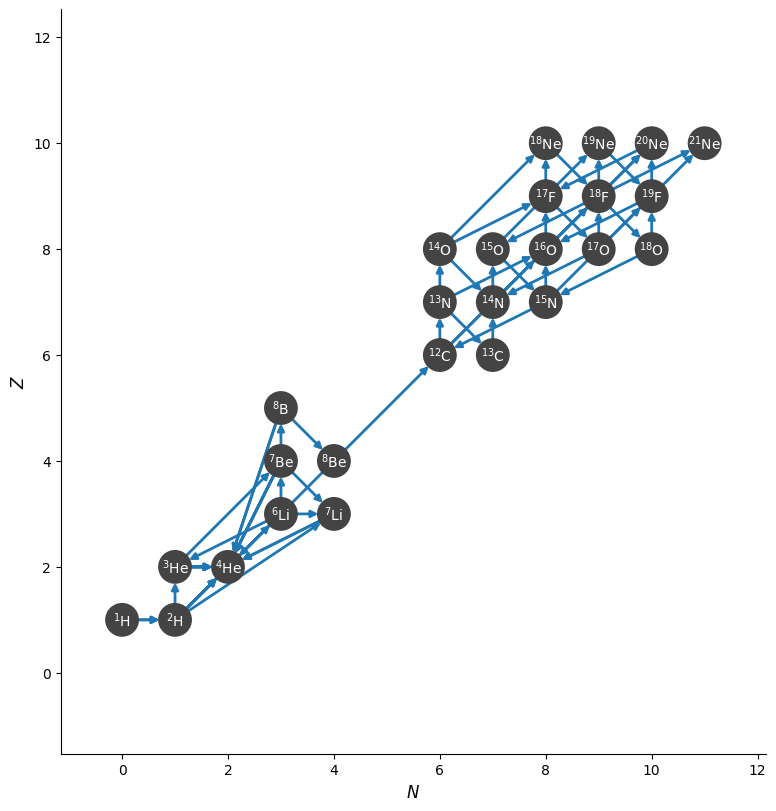

In [5]:
fig = net.plot(hide_xalpha=True, hide_xp=True,
               node_size=500, node_font_size=10,
               size=(800, 800))

## Spectral radius

Now we'll choose conditions appropriate to the base of the convective H-burning envelope in a classical nova.

```{important}
The spectral radius will depend somewhat on the composition of the trace nuclei, so they should be varied in any analysis to cover what would be expected in a simulation.
```

In [6]:
rho = 1700
T = 7.e7
comp = pyna.Composition(net.unique_nuclei)
comp.set_all(1.e-6)
comp.set_nuc("h1", 0.7)
comp.set_nuc("he4", 0.28)
comp.set_nuc("n14", 0.02)
comp.normalize()

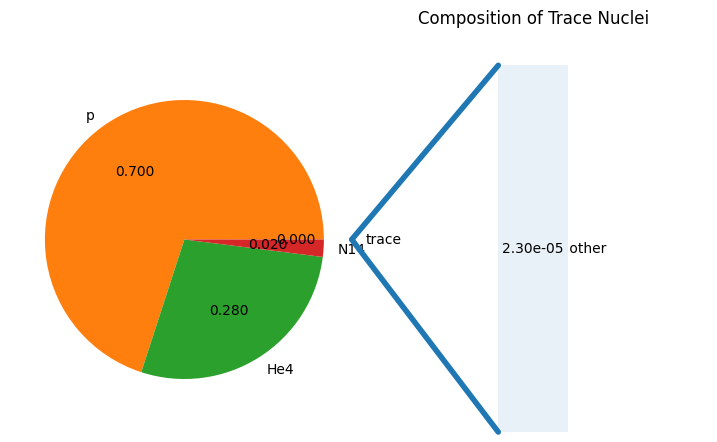

In [7]:
fig = comp.plot(trace_threshold=0.01)

If we evaluate the spectral radius, we see that it is reasonably large.

In [8]:
sprad = net.spectral_radius(rho, T, comp)
print(f"{sprad:12.7g}")

    345703.3


## Alleviating stiffness

We can try to understand which rate is responble for making the spectral radius large by looping over each rate and recomputing the spectral radius without that rate included.

In [9]:
for r in net.get_rates():
    print(f"{r.fname:35} ({r.Q:6.2f}):  {net.spectral_radius(rho, T, comp, exclude_rates=[r]):9.2f}")

Be7__Li7__weak__electron_capture    (  0.86):  345703.34
B8__Be8__weak__wc17                 ( 17.98):  345703.34
N13__C13__weak__wc12                (  2.22):  345703.34
O14__N14__weak__wc12                (  5.14):  345703.34
O15__N15__weak__wc12                (  2.75):  345703.34
F17__O17__weak__wc12                (  2.76):  345703.34
F18__O18__weak__wc12                (  1.66):  345703.34
Ne18__F18__weak__wc12               (  4.44):  345703.34
Ne19__F19__weak__wc12               (  3.24):  345703.34
B8__He4_He4__weak__wc12             ( 18.07):  345703.34
p_p__d__weak__bet_pos_              (  1.44):  345703.34
p_p__d__weak__electron_capture      (  1.44):  345703.34
p_d__He3                            (  5.49):  345703.34
d_d__He4                            ( 23.85):  345703.34
He4_d__Li6                          (  1.47):  345703.34
p_He3__He4__weak__bet_pos_          ( 19.80):  345703.34
He4_He3__Be7                        (  1.59):  345703.34
p_Li6__Be7                     

From here we see that it is just the ${}^6\mathrm{Li}(\mathrm{p},{}^3\mathrm{He}){}^4\mathrm{He}$ rate that is responsible.  Removing that rate drops the spectral radius by almost $50\times$.

We can look at all the rates that involve ${}^6\mathrm{Li}$ and see how fast they are:

In [10]:
rates = net.evaluate_rates(rho, T, comp)

In [11]:
for r in net.get_rates():
    if pyna.Nucleus("li6") in r.reactants + r.products:
        print(r, rates[r])

H2 + He4 ⟶ Li6 + 𝛾 6.902655749081773e-11
Li6 + p ⟶ Be7 + 𝛾 1.9335397883565184e-06
Li6 + p ⟶ He4 + He3 0.0576139258675003
Li6 + H2 ⟶ p + Li7 2.5784505974031287e-08


This shows that the same rate responsible for increasing the spectral radius is also the fastest rate involving ${}^6\mathrm{Li}$.

At this stage, there are a few paths that can be taken.

Based on the rate strengths, we might not ever need to consider ${}^4\mathrm{He}(\mathrm{d}, \gamma){}^6\mathrm{Li}$, which removes the production of ${}^6\mathrm{Li}$ from the network completely, so we could just remove that nucleus.  This would be reasonable if there were something else that consumes $\mathrm{d}$ much faster.  Let's see:

In [12]:
for r in net.get_rates():
    if pyna.Nucleus("d") in r.reactants:
        print(r, rates[r])

H2 + p ⟶ He3 + 𝛾 0.0013628129288238144
H2 + H2 ⟶ He4 + 𝛾 1.7810027635650437e-12
H2 + He4 ⟶ Li6 + 𝛾 6.902655749081773e-11
He3 + H2 ⟶ p + He4 3.117040364361626e-06
Li6 + H2 ⟶ p + Li7 2.5784505974031287e-08
Be7 + H2 ⟶ p + He4 + He4 6.126324691465521e-11


All of these rates are much faster than ${}^4\mathrm{He}(\mathrm{d}, \gamma){}^6\mathrm{Li}$, so it does seem reasonable that we can just remove that nucleus.

Alternately, we can approximate out ${}^6\mathrm{Li}$ by assuming equilibrium of the 4 rates listed above, setting:

$$\frac{dY({}^6\mathrm{Li})}{dt} = 0$$

and then write effective rates that link to ${}^7\mathrm{Li}$ and ${}^7\mathrm{Be}$.